In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from IPython.display import clear_output
from skimage import io

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_xray_df.sample(11)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(11)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3431,00016918_017.png,No Finding,17,16918,064Y,M,AP,2500,2048,0.168,0.168
2809,00014004_013.png,Nodule,13,14004,058Y,F,AP,2604,2544,0.139,0.139
817,00004338_002.png,Edema,2,4338,050Y,M,AP,2500,2048,0.171,0.171
2351,00011925_049.png,No Finding,49,11925,054Y,M,AP,2500,2048,0.168,0.168
404,00002115_001.png,No Finding,1,2115,046Y,M,PA,2992,2991,0.143,0.143
483,00002524_033.png,No Finding,33,2524,058Y,M,PA,2918,2991,0.143,0.143
3259,00016083_005.png,Atelectasis|Infiltration,5,16083,057Y,M,PA,2992,2991,0.143,0.143
982,00005107_000.png,Nodule,0,5107,044Y,F,PA,2048,2500,0.171,0.171
3656,00017994_004.png,Mass|Pneumothorax,4,17994,060Y,F,PA,2726,2521,0.143,0.143
344,00001836_069.png,Fibrosis|Infiltration,69,1836,050Y,F,AP,2500,2048,0.168,0.168


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_xray_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_xray_labels = [x for x in all_xray_labels if len(x)>0]
print("Number of labels: {}\nLabels: {}".format(len(all_xray_labels),", ".join(all_xray_labels)))

for c_label in all_xray_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df.sample(3)

Number of labels: 15
Labels: Atelectasis, Cardiomegaly, Consolidation, Edema, Effusion, Emphysema, Fibrosis, Hernia, Infiltration, Mass, No Finding, Nodule, Pleural_Thickening, Pneumonia, Pneumothorax


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
83709,00020540_004.png,No Finding,4,20540,58,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
52268,00013194_009.png,No Finding,9,13194,50,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
65264,00016109_009.png,Infiltration,9,16109,49,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
all_xray_df["pneumonia_class"] = all_xray_df["Pneumonia"].map(lambda pneumonia: "yes" if pneumonia == 1.0 else "no")
all_xray_df["pneumonia_class"] = all_xray_df["pneumonia_class"].astype(str)
all_xray_df.sample(25)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
56143,00014004_024.png,Infiltration,24,14004,58,F,AP,3056,2544,0.139000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,no
98016,00025849_060.png,No Finding,60,25849,58,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
14880,00003882_004.png,No Finding,4,3882,51,M,PA,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
61795,00015267_004.png,No Finding,4,15267,38,M,PA,2880,2963,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
104162,00027819_000.png,Infiltration|Nodule,0,27819,50,F,PA,2990,2991,0.143000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,no
78854,00019363_018.png,No Finding,18,19363,55,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
62015,00015344_005.png,No Finding,5,15344,56,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
58418,00014443_002.png,No Finding,2,14443,65,F,PA,2936,2948,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
83876,00020617_001.png,No Finding,1,20617,60,M,PA,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
71246,00017557_004.png,Infiltration|Mass,4,17557,44,M,AP,2500,2048,0.168000,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,no


In [5]:


all_xray_df.loc[all_xray_df['Patient Age']>100]



,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,yes
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,no
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,no
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,no
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,no


In [6]:


all_xray_df.loc[all_xray_df['Pneumonia']==1]



,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,yes
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,yes
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,yes
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,yes
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111557,00030536_007.png,Atelectasis|Consolidation|Pneumonia,7,30536,56,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,yes
111627,00030570_001.png,Edema|Infiltration|Pneumonia,1,30570,29,F,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,yes
111767,00030621_002.png,Pneumonia,2,30621,22,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,yes
111845,00030637_016.png,Consolidation|Pneumonia,16,30637,48,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,yes


(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <BarContainer object of 10 artists>)

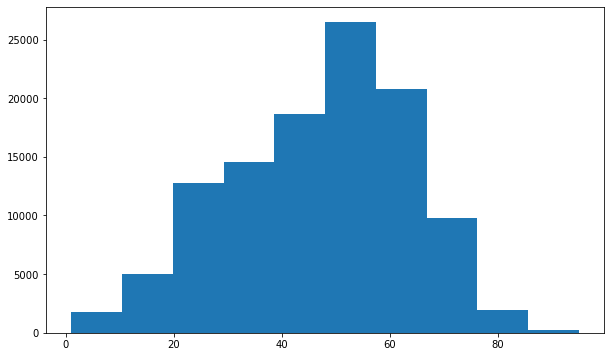

In [7]:


plt.figure(figsize=(10,6))
all_xray_df = all_xray_df.loc[all_xray_df['Patient Age'] < 100]
plt.hist(all_xray_df['Patient Age'])



(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <BarContainer object of 10 artists>)

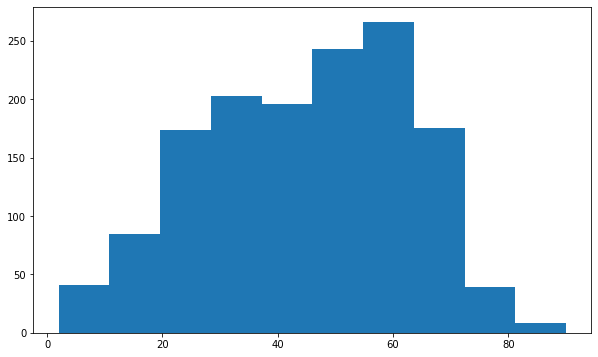

In [8]:


plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'])



In [9]:


colors_list = ['#5cb85c','#ffe873']



<AxesSubplot:>

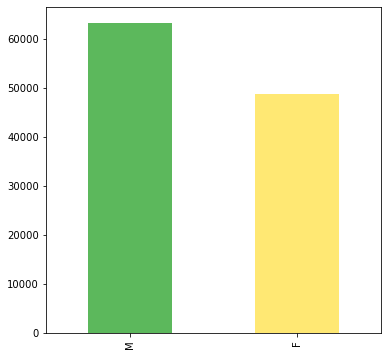

In [10]:
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar', color=colors_list)

<AxesSubplot:>

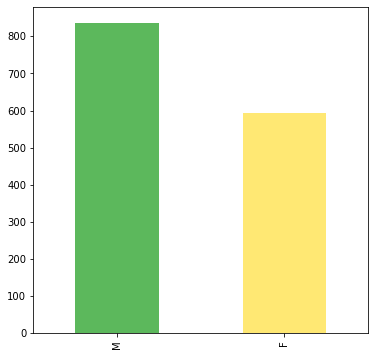

In [11]:


plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar', color=colors_list)



<AxesSubplot:>

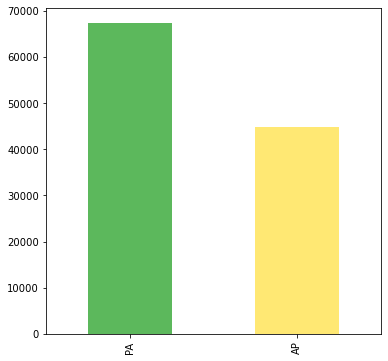

In [12]:
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar', color = colors_list)

[Text(0, 0.5, 'Number of Images with Label')]

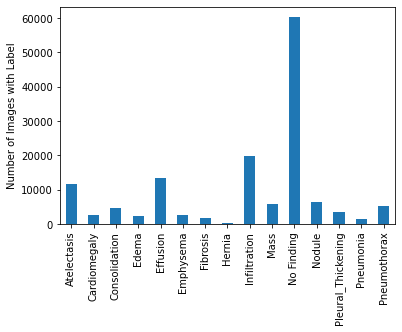

In [13]:
ax = all_xray_df[all_xray_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

In [14]:
# Number of patients for each diseases
all_xray_df[all_xray_labels].sum()

Atelectasis           11558.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2302.0
Effusion              13316.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19891.0
Mass                   5779.0
No Finding            60353.0
Nodule                 6331.0
Pleural_Thickening     3384.0
Pneumonia              1430.0
Pneumothorax           5301.0
dtype: float64

In [15]:


# Percentage of each diseases in the whole data
all_xray_df[all_xray_labels].sum()/len(all_xray_df)*100



Atelectasis           10.310069
Cardiomegaly           2.476272
Consolidation          4.163099
Edema                  2.053450
Effusion              11.878256
Emphysema              2.244345
Fibrosis               1.503961
Hernia                 0.202491
Infiltration          17.743345
Mass                   5.155035
No Finding            53.836616
Nodule                 5.647435
Pleural_Thickening     3.018626
Pneumonia              1.275601
Pneumothorax           4.728645
dtype: float64

In [16]:
# Number of pneumonia cases
num_pneumonia = all_xray_df['Pneumonia'].sum()
print("Number of pneumonia cases: {}".format(num_pneumonia))

# Number of non-pneumonia cases and has other disease
num_non_pneumonia = len(all_xray_df.loc[(all_xray_df['Pneumonia']==0) & (all_xray_df['No Finding']!=0)])
print("Number of non-pneumonia cases: {}".format(num_non_pneumonia))

Number of pneumonia cases: 1430.0
Number of non-pneumonia cases: 60353


<AxesSubplot:>

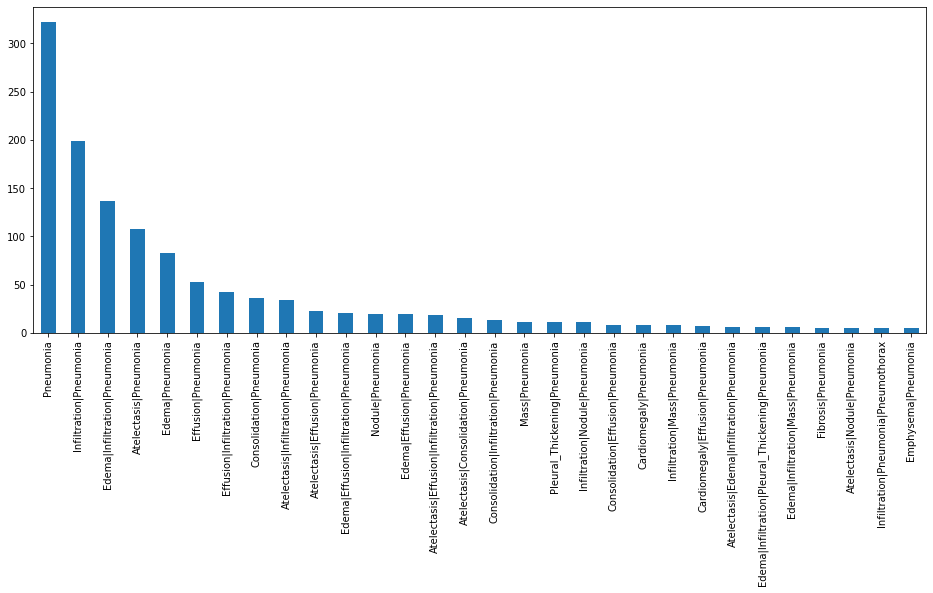

In [17]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

Number of Diseases
0.0    60353
1.0    30959
2.0    14302
3.0     4856
4.0     1247
5.0      301
6.0       67
7.0       16
8.0        1
9.0        2
Name: Number of Diseases, dtype: int64


C:\Users\sethr\AppData\Local\Temp/ipykernel_15980/420651767.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  number_of_diseases_per_person = all_xray_df.iloc[:,11:].sum(axis=1) - all_xray_df['No Finding']


[Text(0, 0.5, 'Number of Patients')]

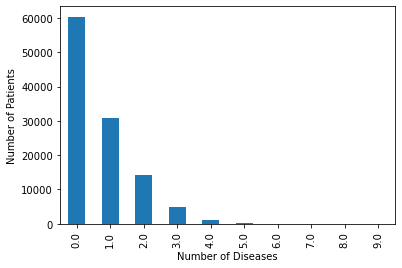

In [18]:


number_of_diseases_per_person = all_xray_df.iloc[:,11:].sum(axis=1) - all_xray_df['No Finding']
df = pd.DataFrame(number_of_diseases_per_person, columns=['Number of Diseases'])

group_number = df.groupby("Number of Diseases")["Number of Diseases"].count()
print(group_number)

ax = group_number.plot(kind = 'bar')
ax.set(ylabel = 'Number of Patients')

In [19]:
images = []
for i, img_id in enumerate(sample_df['Image Index']):
    clear_output(wait=True)
    path = glob(os.path.join("data","images*","*",img_id))[0]
    print("Loaded {}/{}".format(i+1, len(sample_df)))
    img = io.imread(path)
    images.append(img)

Loaded 5606/5606


In [20]:
def sample_stack(images, rows=7, cols=7, start_with=0, show_every=100):
    fig,ax = plt.subplots(rows,cols,figsize=[15,15])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('Image %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(images[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

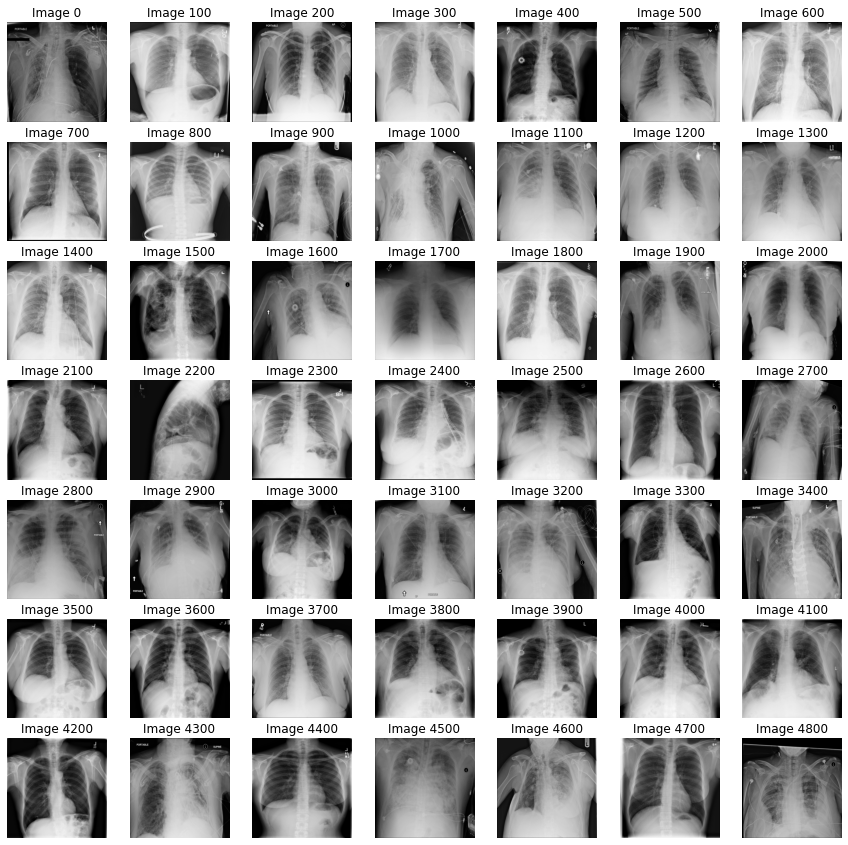

In [21]:
sample_stack(images)

In [22]:


def normalize_image(image):
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    new_image = image.copy()
    new_image = (new_image - mean_intensity)/std_intensity
    return new_image



In [23]:
intensity_images = []
for i, image in enumerate(images):
    clear_output(wait=True)
    intensity_images.append(np.mean(image))
    print("Done {}/{}".format(i, len(images)))
intensity_images = np.array(intensity_images)

Done 5605/5606


In [24]:
new_images = []
for i, image in enumerate(images):
     clear_output(wait=True)
     new_images.append(normalize_image(image))
     print("Normalized {}/{}".format(i+1, len(images)))

Normalized 5606/5606


## Pixel Level Assessments

In [71]:
#sample_df will be used for this EDA
samp_labels=np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
samp_labels=[x for x in samp_labels if len(x)>0]
print(samp_labels)

for label in samp_labels:
    if len(label)>1:
        sample_df[label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
sample_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# Find image paths for png listed.  Code from Model section
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.head()

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,data\images_001\images\00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data\images_001\images\00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images_001\images\00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data\images_001\images\00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data\images_001\images\00000032_001.png


Text(0.5, 1.0, 'No Finding AP Position')

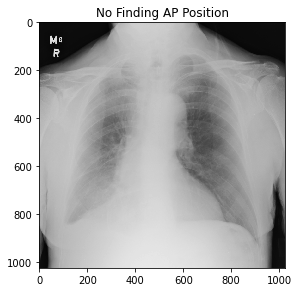

In [73]:
#AP Position
sampimg1=io.imread('data/images_001/images/00000017_001.png')
io.imshow(sampimg1, cmap='gray')
plt.title('No Finding AP Position')

Text(0.5, 1.0, 'Emphysema|Infiltration|Pleural_Thickening|Pneu...\t')

C:\anaconda\envs\Udacity\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
C:\anaconda\envs\Udacity\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


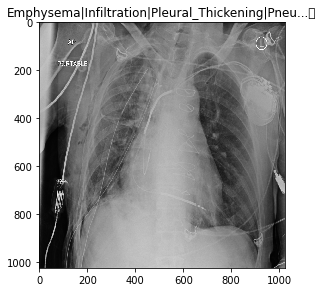

In [74]:
#AP Position
sampimg2=io.imread('data/images_001/images/00000013_001.png')
io.imshow(sampimg2, cmap='gray')
plt.title('Emphysema|Infiltration|Pleural_Thickening|Pneu...	')

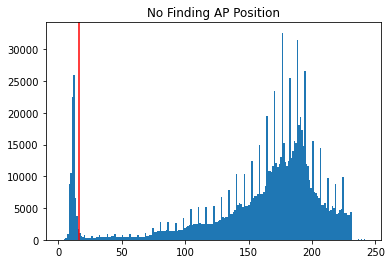

In [75]:
plt.hist(sampimg1.ravel(),bins=200)
plt.title('No Finding AP Position')
plt.axvline(16,color='red')
plt.show()

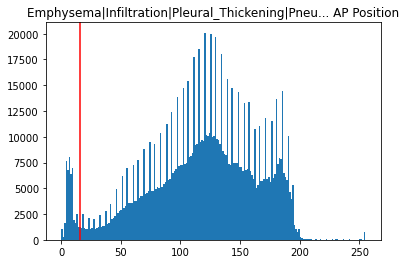

In [76]:
plt.hist(sampimg2.ravel(),bins=200)
plt.title('Emphysema|Infiltration|Pleural_Thickening|Pneu... AP Position')
plt.axvline(16,color='red')
plt.show()

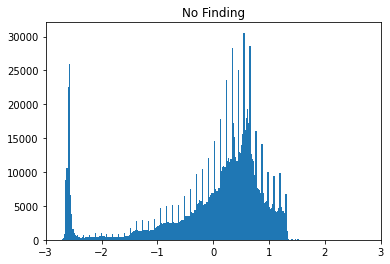

In [77]:
#Normalize Image Data
normimg1=(sampimg1-sampimg1.mean())/sampimg1.std()
plt.hist(normimg1.ravel(), bins=200)
plt.xlim(-3,3)
plt.title('No Finding')
plt.show()

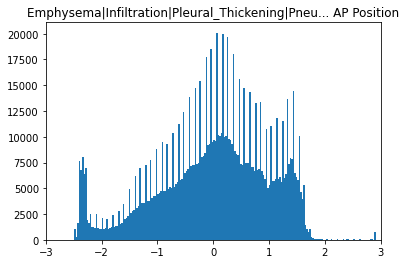

In [78]:
normimg2=(sampimg2-sampimg2.mean())/sampimg2.std()
plt.hist(normimg2.ravel(), bins=200)
plt.xlim(-3,3)
plt.title('Emphysema|Infiltration|Pleural_Thickening|Pneu... AP Position')
plt.show()

   ## PA Position EDA

In [79]:
#PA Position
sample_dfPA=sample_df[sample_df['View Position']=='PA']

In [80]:
sample_dfPA[sample_dfPA['Pneumonia']==1]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
287,00001529_004.png,Consolidation|Infiltration|Pneumonia,4,1529,054Y,F,PA,2992,2991,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,data\images_002\images\00001529_004.png
382,00001993_000.png,Infiltration|Nodule|Pneumonia,0,1993,011Y,F,PA,2048,2500,0.168000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,data\images_002\images\00001993_000.png
775,00004074_000.png,Mass|Nodule|Pneumonia,0,4074,047Y,M,PA,2500,2048,0.171000,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,data\images_003\images\00004074_000.png
776,00004075_000.png,Atelectasis|Pneumonia,0,4075,032Y,F,PA,2048,2500,0.171000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,data\images_003\images\00004075_000.png
1305,00006843_000.png,Atelectasis|Pneumonia,0,6843,005Y,F,PA,2048,2500,0.171000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,data\images_004\images\00006843_000.png
1573,00008154_000.png,Atelectasis|Consolidation|Mass|Pneumonia,0,8154,053Y,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,data\images_004\images\00008154_000.png
1683,00008763_001.png,Nodule|Pneumonia,1,8763,061Y,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,data\images_004\images\00008763_001.png
2035,00010552_005.png,Infiltration|Pneumonia,5,10552,039Y,M,PA,2622,2991,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,data\images_005\images\00010552_005.png
2148,00011104_004.png,Infiltration|Nodule|Pneumonia,4,11104,060Y,M,PA,2992,2991,0.143000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,data\images_005\images\00011104_004.png
2422,00012158_025.png,Pneumonia,25,12158,047Y,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,data\images_006\images\00012158_025.png


Text(0.5, 1.0, 'Pneumonia PA Position')

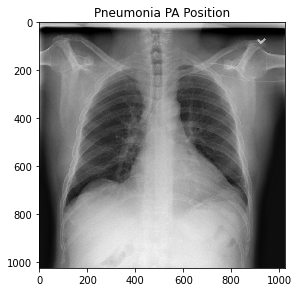

In [81]:
sampimgPA1=io.imread('data/images_009/images/00019021_001.png')
io.imshow(sampimgPA1, cmap='gray')
plt.title('Pneumonia PA Position')

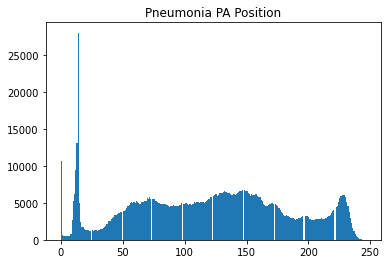

In [82]:
plt.hist(sampimgPA1.ravel(),bins=256)
plt.title('Pneumonia PA')
plt.title('Pneumonia PA Position')
plt.show()

In [83]:
normimgPA1 = (sampimgPA1-sampimgPA1.mean())/sampimgPA1.std()

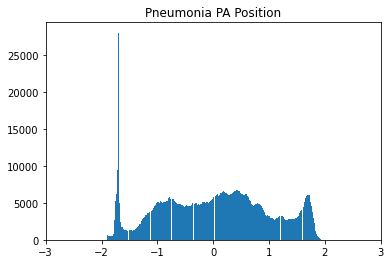

In [84]:
plt.hist(normimgPA1.ravel(),bins=256)
plt.xlim(-3,3)
plt.title('Pneumonia PA Position')
plt.show()

In [85]:
sample_dfPA[sample_dfPA['No Finding']==1]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
12,00000080_005.png,No Finding,5,80,067Y,F,PA,1884,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images_001\images\00000080_005.png
13,00000083_000.png,No Finding,0,83,056Y,F,PA,2048,2500,0.171000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images_001\images\00000083_000.png
28,00000165_008.png,No Finding,8,165,078Y,M,PA,2940,2900,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images_001\images\00000165_008.png
34,00000188_001.png,No Finding,1,188,045Y,M,PA,2698,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images_001\images\00000188_001.png
35,00000194_004.png,No Finding,4,194,084Y,F,PA,2614,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images_001\images\00000194_004.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5596,00030636_017.png,No Finding,17,30636,046Y,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images_012\images\00030636_017.png
5600,00030704_000.png,No Finding,0,30704,052Y,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images_012\images\00030704_000.png
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images_012\images\00030712_000.png
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\images_012\images\00030792_000.png


Text(0.5, 1.0, 'No Finding PA Position')

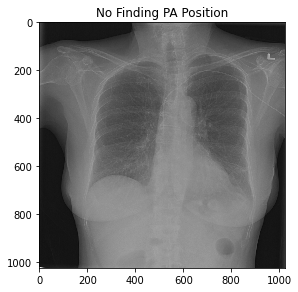

In [86]:
sampimgPA2=io.imread('data/images_001/images/00000080_005.png')
io.imshow(sampimgPA2)
plt.title('No Finding PA Position')

In [87]:
normimgPA2= (sampimgPA2-sampimgPA2.mean())/sampimgPA2.std()

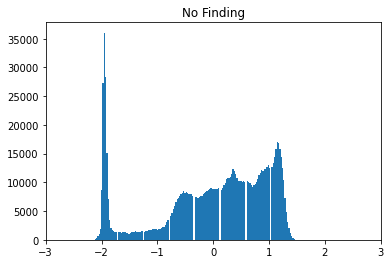

In [88]:
plt.hist(normimgPA2.ravel(),bins=256)
plt.title('No Finding')
plt.xlim(xmin=-3,xmax=3)
plt.show()

## The no Pneumania and with Pneumonia exhibit different intensity characteristic - specifically peak values. Exclusing the peaks outside of lungs the no-pneumonia exhibit higher peaks than the pneumonia cases

## EDA within Pneumonia and co-morbity

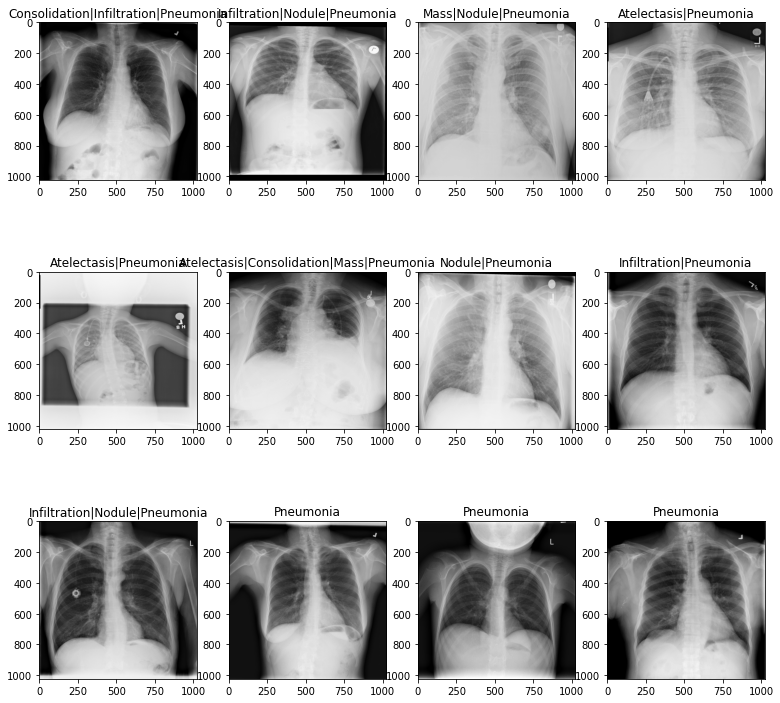

In [89]:

#PA Position with Pneumonia
fig, n_axis=plt.subplots(3,4,figsize=(13,13))
n_axis=n_axis.flatten()

for x in range(12):
    img=io.imread(sample_dfPA[sample_dfPA['Pneumonia']==1.0].iloc[x]['path'])
    n_axis[x].imshow(img,cmap="gray")
    n_axis[x].set_title(sample_dfPA[sample_dfPA['Pneumonia']==1.0].iloc[x]['Finding Labels'])

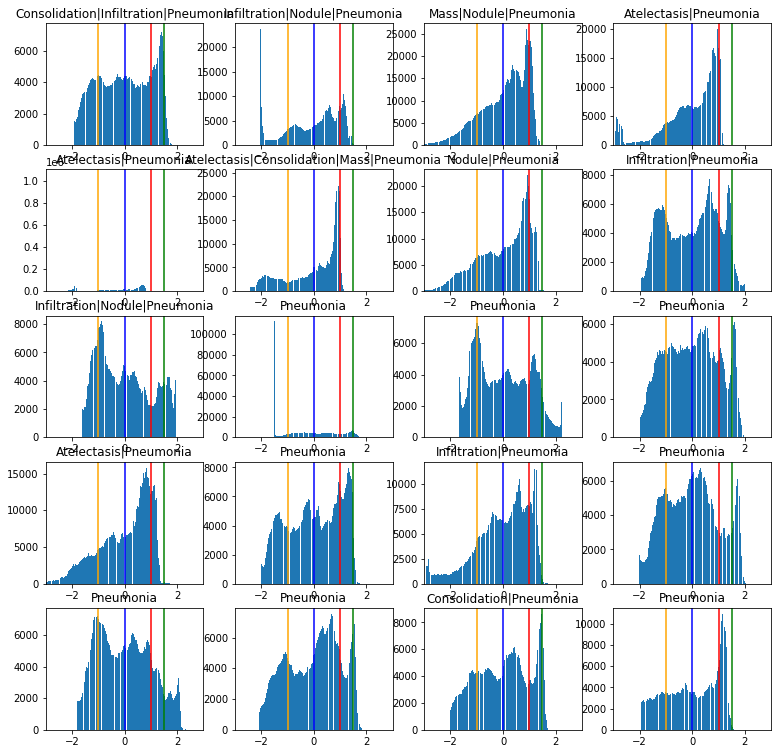

In [90]:
#PA Position with Pneumonia
fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()

for x in range(20):
    img=io.imread(sample_dfPA[sample_dfPA['Pneumonia']==1.0].iloc[x]['path'])
    img= img[img>16]
    
    normimg = (img-img.mean())/img.std()
    n_axis[x].hist(normimg.flatten(), bins=256)
    n_axis[x].set_title(sample_dfPA[sample_dfPA['Pneumonia']==1.0].iloc[x]['Finding Labels'])
    n_axis[x].set_xlim(-3,3)
    n_axis[x].axvline(1, color='red')
    n_axis[x].axvline(1.5, color='green')
    n_axis[x].axvline(0, color='blue')
    n_axis[x].axvline(-1., color='orange')

## It is not easy to glean a specific pattern among the different categories of comorbid cases and without morbidity. We need to look beyond the intensity for any specific asssertions.

## AP Position EDA

In [91]:
#AP Position
sample_dfAP=sample_df[sample_df['View Position']=='AP']

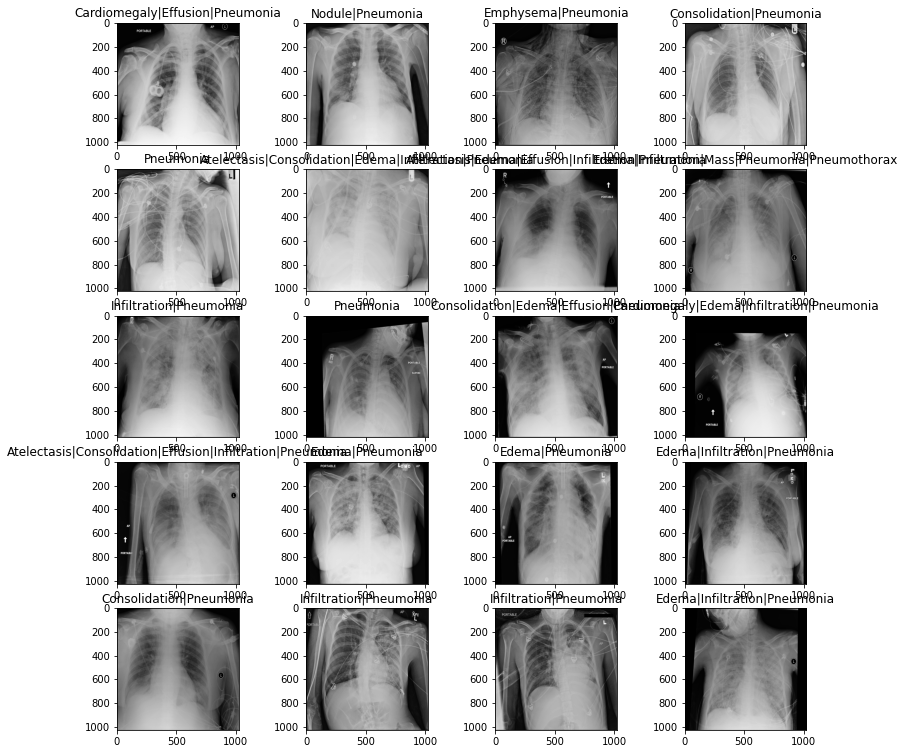

In [92]:
#AP Position with Pneumonia
fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()

for x in range(20):
    img=io.imread(sample_dfAP[sample_dfAP['Pneumonia']==1.0].iloc[x]['path'])
    n_axis[x].imshow(img,cmap="gray")
    n_axis[x].set_title(sample_dfAP[sample_dfAP['Pneumonia']==1.0].iloc[x]['Finding Labels'])

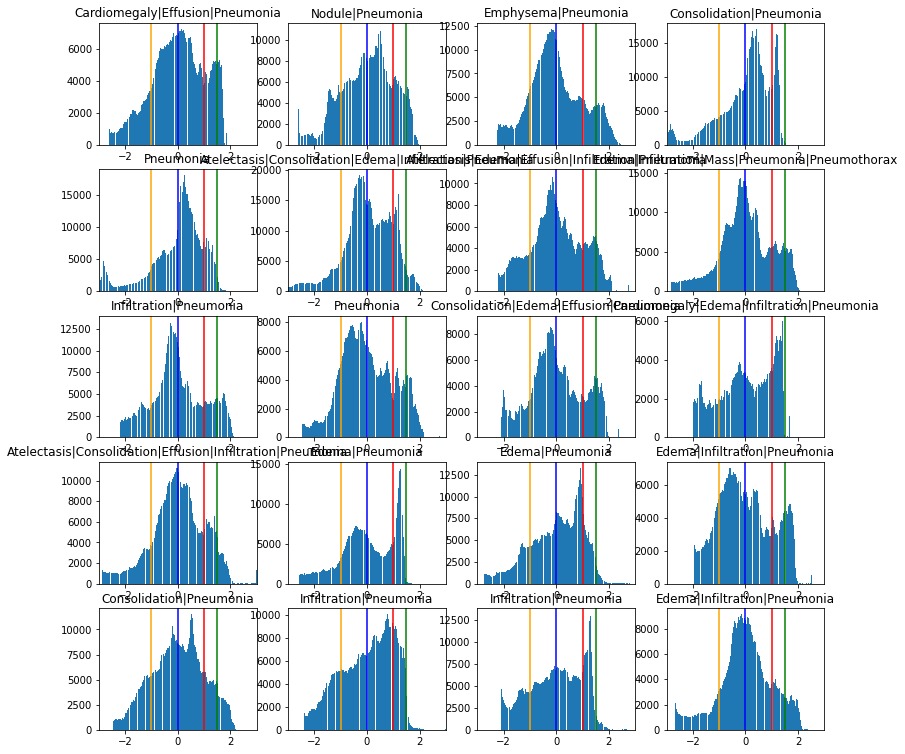

In [93]:
#AP Position with Pneumonia
fig, n_axis=plt.subplots(5,4,figsize=(13,13))
n_axis=n_axis.flatten()

for x in range(20):
    img=io.imread(sample_dfAP[sample_dfAP['Pneumonia']==1.0].iloc[x]['path'])
    img= img[img>16]
    normimg = (img-img.mean())/img.std()
    n_axis[x].hist(normimg.flatten(), bins=256)
    n_axis[x].set_title(sample_dfAP[sample_dfAP['Pneumonia']==1.0].iloc[x]['Finding Labels'])
    n_axis[x].set_xlim(-3,3)
    n_axis[x].axvline(1, color='red')
    n_axis[x].axvline(1.5, color='green')
    n_axis[x].axvline(0, color='blue')
    n_axis[x].axvline(-1., color='orange')

## There is a discernable difference in AP and PA. AP has single large intensity as against multiple peaks in in PA except in the case of edema. However we need a much trained eye or more EDAs to see a repeating pattern